#### This notebook checks our base code, specifically the method of finding transition points. It also plots backgrounds at different positions. 

In [97]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import glob
import time
import pandas as pd
import math
#import File_functions
plt.rcParams["figure.figsize"] = (3,3)
print (time.ctime())

Mon Nov 15 06:57:16 2021


In [13]:
def One(x,y,file,afterpulse_control = True):
    
    One.filename = file
    x1,y1=x,y

    old_data_table = pd.read_csv(f'{filename}')
    old_data_table = old_data_table.drop(columns = 'Unnamed: 0')
    old_data_table['time'] = ((25*old_data_table['time'])/(4096))*1e-9 #Output in s
    
    R = 2
    R1 = R
    Ion_1 = (
        old_data_table.query(f"((x-{x1})**2 + (y-{y1})**2)**(1/2) <= {R1}")
        .reset_index(drop=True)
    )
    name = Ion_1
    dt = []
    for i in range(0, len(name)-1):
        dt.append(name.at[i+1, 'time'] - name.at[i, 'time'])
    dt.insert(0,0)
    Ion_1['dt'] = dt
    
    if afterpulse_control:
        Ion_1.query(f' dt > 1e-7', inplace = True) # eliminate after pulsing effects, this prevents breaks in dark states, and peaks at 0(s) bright states
        Ion_1.reset_index(inplace = True)
    Ion_1['index'] = np.arange(len(name))
    
    
    One.data_table = Ion_1
    data_table= Ion_1
    One.ion_1=Ion(1, x, y, R, Ion_1, debugPrinting=False)
     
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
    ax1.hist2d(old_data_table['x'], old_data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
    
    ax2.hist2d(data_table['x'], data_table['y'], range = [(min(data_table['x'])-2, max(data_table['x'])+2), (min(data_table['y'])-2, max(data_table['y'])+2)], bins = (int(max(data_table['x']) - min(data_table['x']) +5) , int(max(data_table['y']) - min(data_table['y']) +5)))
    
    plt.show()

In [14]:
def expon(x, rate, multiplier):   # in scipy.stats.expon() the paramater 
                                      #'scale = 1 / rate' when inputing the function
        return multiplier * np.exp(-rate * x)
class Ion:
    def __init__(self, n, x, y, r0, data, debugPrinting=False):
        self.filename=One.filename
        self.n = n # Ion number (left to right)
        self.x = x # x-position
        self.y = y # y-position
        self.r0 = r0 # radius
 
        self.data = data # Dataframe used (data_table in choose_file)
        
        
        self.threshold = [] # differentiator between bright/dark states by 'dt' between events in ROI
        
        self.bright = [] # stores data for only bright events
        self.dark = [] # stores data for only dark events
        
        self.transpts = []  # Transition points (index number)
        # DtB = dark to bright
        # BtD = bright to dark
        self.tofBright=[]
        self.tofDark=[]
        self.dtDark=[]
        self.dtBright=[]
        self.DtB = []
        self.BtD = []
        self.brightRanges = []
 
    def auto_threshold(self,sigma, uncertainty_control ): 
                
            
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))
                bin_heights, bin_borders, _ = ax1.hist(self.data['dt'], bins = 'auto', range = (0, .05), alpha = .5, label='\'dt\' pdf', density = True)
                bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
                popt, pcov = curve_fit(expon, bin_centers, bin_heights, p0=[1/5e-4, bin_heights.max()])
                
                # fits the histogram to exponential. Input parameters for a specific data set but they seem to be pretty applicable to all datasets. 

                x_interval_for_fit = np.linspace(bin_centers[0], bin_centers[-1], 10000)       # define x values for fit
                ax1.plot(x_interval_for_fit, expon(x_interval_for_fit, *popt), label='fit')    # plot exponential fit on top of histogram
                ax1.set_yscale('log')      
                 # Display parameters 
                ax1.set_title(f'{filename} Ion #{self.n}')
                ax1.set_ylabel(f'Probability (log-base)');
                ax1.set_xlabel(f'Time between events in ROI (s)')

                # This part determines the theshold for the Bright/Dark state detection. Unless specified, the value 
                # will be set at the 2 sigma location based on fit params
                sigma_percent = stats.norm.cdf(sigma)                                                                # determine how much of the data should be used. %
                loc = 0; rate = popt[0] ; 
                
                int_to = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / rate)        # turns percent into a number (threshold value)
                print (int_to)
                #int_to=th
                
                self.upper_limit = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / (rate-(pcov[0][0]**2)))
                self.lower_limit = stats.expon.ppf((sigma_percent), loc=loc, scale= 1 / (rate+(pcov[0][0]**2)))

            #print (rate,"rate"),;print (pcov[0][0]**2,"sqrt"),; print ((rate-(pcov[0][0]**2)),"rate upper") 

                d = stats.expon.rvs(loc = loc, scale = rate, size = 10000)                                          # create random variables that follow the fit (for plotting)
                base = np.linspace(0,int_to,100000)
                ax1.plot(base,stats.expon.pdf(base,loc = loc, scale = 1 / rate), 'r', linewidth = 2,alpha = 0.4)     
                int_base1 = np.linspace(0,int_to,10000)                                                      #(below) plot a shaded region that displays the bright state values
                ax1.fill_between(int_base1, stats.expon.pdf(int_base1,loc = loc, scale = 1 / rate), color = 'b', linewidth = 0, alpha = .3, label = 'Bright')
                ax1.set_xlim(0, 2*int_to)
                ax1.legend()

                if uncertainty_control:
                    ax1.axvline(self.lower_limit)
                    ax1.axvline(self.upper_limit)


                #Print statements that tell you about the threshold and the fit parameters etc. 
                prob = 1 - stats.expon.cdf(int_to, loc=loc, scale= 1 / rate)
                z = (stats.norm.ppf(1-(prob)))
                #print(f'Ion {self.n} threshold: {int_to:.2e}(s)' )
                #print(f'Fit Parameters: [rate (lambda) = {popt[0]:.3e}] || [multiplier = {popt[1]:.3e}] \n')

                #Plot everything on a non-log base y-scale. 
                ax2.hist(self.data['dt'], bins = 'auto', range = (0, .05), alpha = .5, label='\'dt\' pdf', density = True)
                ax2.plot(x_interval_for_fit, expon(x_interval_for_fit, *popt), label='fit')
                ax2.set_title(f'{filename} Ion #{self.n}')
                ax2.set_ylabel(f'Probability')
                ax2.set_xlabel(f'Time between events in ROI (s)')
                ax2.plot(base,stats.expon.pdf(base,loc = loc, scale = 1 / rate), 'r', linewidth = 2,alpha = 0.4)
                ax2.fill_between(int_base1, stats.expon.pdf(int_base1,loc = loc, scale = 1 / rate), color = 'b', linewidth = 0, alpha = .3, label = 'Bright')
                ax2.set_ylim(0,bin_heights.max()*1.05)
                ax2.set_xlim(0, 2*int_to)
                ax2.legend()
                fig.tight_layout()

                self.threshold = int_to
                #print(self.threshold)
            
    def sortbythreshold(self, uncertainty_control = True):
        
        
        if uncertainty_control:
            # simple sorting method which sorts data based on the length of pause between events
            self.bright = self.data.query(f'dt < {self.lower_limit}')
            self.dark = self.data.query(f'dt > {self.upper_limit}')
            self.uncertain_state = self.data.query(f'{self.lower_limit} <= dt <= {self.upper_limit}')
        
            for i in self.uncertain_state['index']:
                if i-1 in self.bright['index'] and i+1 in self.bright['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.dark['index'] and i+1 in self.dark['index']:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.bright['index'] and i+1 in self.dark['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.dark['index'] and i+1 in self.bright['index']:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                elif i-1 in self.bright['index']:
                    self.bright = self.bright.append(self.uncertain_state.loc[[i]])
                else:
                    self.dark = self.dark.append(self.uncertain_state.loc[[i]])
                
            self.bright = self.bright.sort_values('time')
            self.dark = self.dark.sort_values('time')
        
        else: 
            self.bright = self.data.query(f'dt < {self.threshold}')
            self.dark = self.data.query(f'dt > {self.threshold}')

            
        #print(f'Bright events (#/%): {len(self.bright)} / {len(self.bright)/len(self.data)*100:.2f}% \n')
        b_or_d = []
        for i in self.data['index']:
            if self.data.at[i, 'dt'] <= self.threshold:
                b_or_d.append(1)
            else:
                b_or_d.append(-1)
        self.data['B/D'] = b_or_d
        
        
        ### plots histogram of 'dt' values separately for Bright/Dark states ### (upperbound made to eliminate regions of extremely long dark states)
    
        ### Locate and save the locations that BtD and DtB transitions occur ###
    def transitions(self, single_photon_control = True):
       
        # identifies points where quantum jumps happen
        # using list comprehension
        misscount = 0
        self.transpts.clear()
        for i in range(len(self.data)) :
            if i not in self.bright['index']:
                misscount = misscount + 1
                if misscount == 1:
                    self.transpts.append(i)
            if i in self.bright['index'] and misscount >= 1:
                misscount = 0
                self.transpts.append(i)
        
        
                
        # DtB = dark to bright
        # BtD = bright to dark
        self.DtB.clear()
        self.BtD.clear()
        for i in range(len(self.transpts)):
            if self.transpts[i] in self.bright['index']:
                self.DtB.append(self.transpts[i])
            else:
                self.BtD.append(self.transpts[i])
                
        ### This functions finds the time between the events ('points') before a BtD transition,
        #  averages each 'point' and plots what can be referred to as an 'average transition' ###
        
    
    
    def setup(self,kind,sigma, uncertainty_control, single_photon_control):
        
        if kind=="auto":
            
            self.auto_threshold(sigma,uncertainty_control)
            self.sortbythreshold(uncertainty_control)
            self.transitions(single_photon_control)
        elif kind=="integration":
            self.FindBrightRangesPrecise(arrT,N)

#--------------------------------------------
#PDFs
#-----
    

    def Lorentzian(x, x0, a, gam, b):
        return b + a * gam**2 / ( gam**2 + ( x - x0 )**2)

    def Double_Lorentzian(x, x1, a1, gam1, b1, x2, a2, gam2):
        return b1 + a1 * gam1**2 / ( gam1**2 + ( x - x1 )**2) + a2 * gam2**2 / ( gam2**2 + ( x - x2 )**2)

    def Linear(x, m, b):
        return m*x + b

    def Oscillation(x, A, B, phase):
        return A + np.abs(B) *np.sin(2*np.pi*(x)/54.789717 + phase)

    def Gaussian(x, xm, sigma, A, c):
        return np.absolute(A)*np.exp(-np.power((x-xm)/sigma,2)/2) + c
               

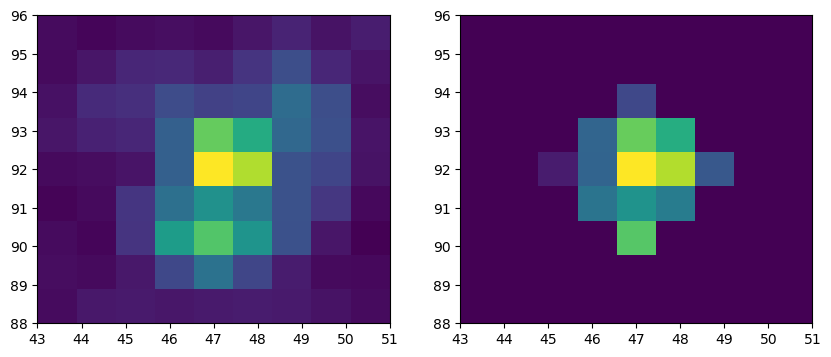

In [15]:
filename='P/x_389.5'
One(x=47,y=92,file=filename)

In [5]:
ion_1=One.ion_1 #ROI of ion centered at x=47

In [6]:
data_table=One.data_table

0.0041960223536629876
Duration:  607.7106369296876 ;	Number of Transitions:  13695


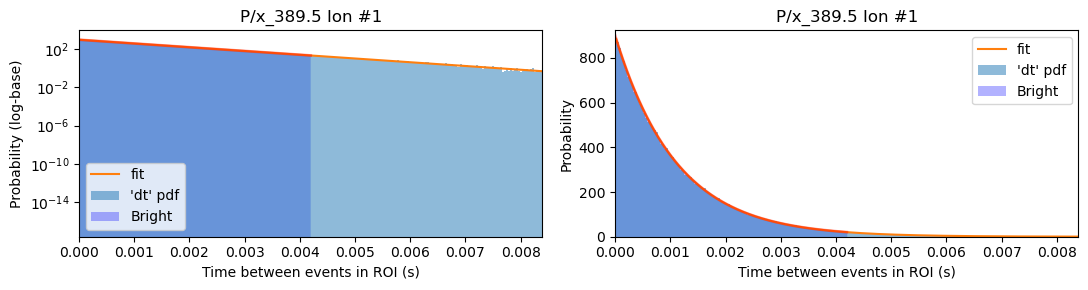

In [7]:
time = (data_table['time'].max() - data_table['time'].min()) #time in seconds 

sigma = 2
uncertainty = False
single_photon = False
kind="auto"
ion_1.setup(kind,sigma, uncertainty, single_photon)

rate_x_389s = [len(ion_1.transpts)/time]
print ("Duration: ",time,";\tNumber of Transitions: ",len(ion_1.transpts))

In [8]:
dark_size,bright_size=len(ion_1.dark),len(ion_1.bright)

In [9]:
print (bright_size/dark_size) #Size comparison of bright and dark points.

40.73033551440902


In [10]:
#Checking if index repeats in bright and dark points. I if index "i" is not in the bright array, 
#then append "i" to "missing".
missing=[]
for i in range (len(data_table["dt"])):
    if i not in ion_1.bright.index:
        missing.append(i)
len(missing)

7183

In [11]:
np.nonzero(np.array(list(ion_1.dark.index))-np.array(missing)) # Element-wise subtraction 
                                                               #Checks non-zero values 

(array([], dtype=int64),)

Index numbers appear to be correct.

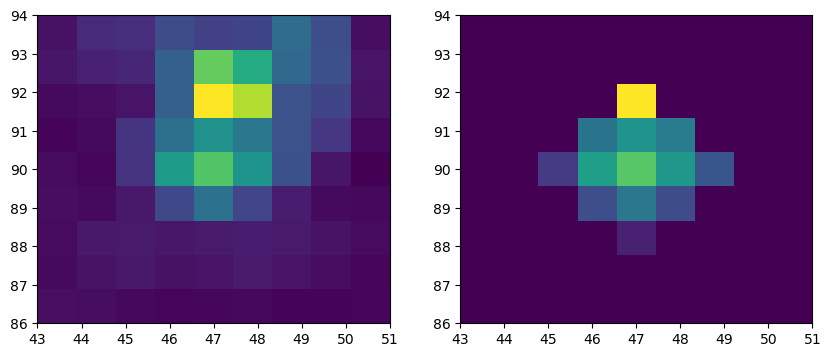

In [77]:
One(x=47,y=90,file=filename) # Region just below ion

0.0049139852251277516
Duration:  607.7106369296876 ;	Number of Transitions:  12274


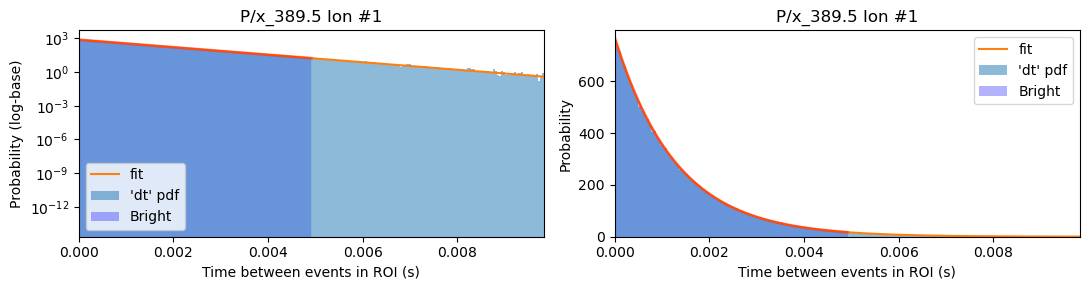

In [81]:
bottom_ion_1=One.ion_1
time = (data_table['time'].max() - data_table['time'].min()) #time in seconds 

sigma = 2
uncertainty = False
single_photon = False
kind="auto"
bottom_ion_1.setup(kind,sigma, uncertainty, single_photon)

rate_x_389s = [len(ion_1.transpts)/time]
print ("Duration: ",time,";\tNumber of Transitions: ",len(bottom_ion_1.transpts))

Threshold increased a bit as expected.

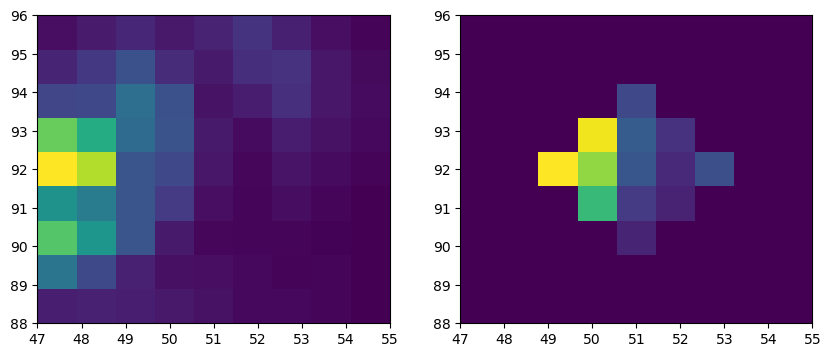

In [85]:
One(x=51,y=92,file=filename) #Region just right of the ion. 

0.01892732745161641
Duration:  607.7106369296876 ;	Number of Transitions:  3794


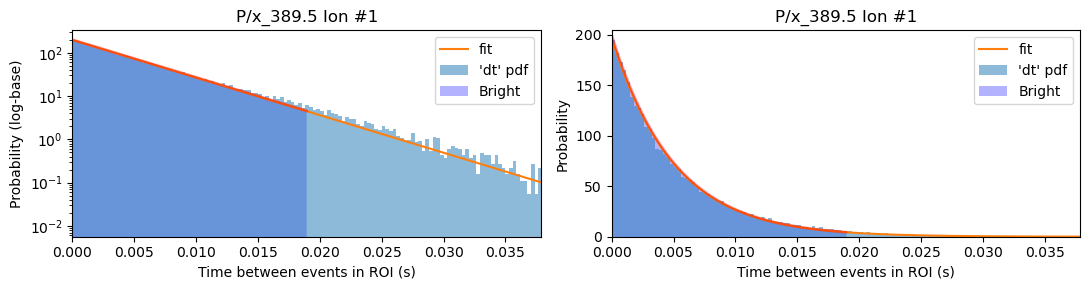

In [86]:
right_ion_1=One.ion_1
time = (data_table['time'].max() - data_table['time'].min()) #time in seconds 

sigma = 2
uncertainty = False
single_photon = False
kind="auto"
right_ion_1.setup(kind,sigma, uncertainty, single_photon)

print ("Duration: ",time,";\tNumber of Transitions: ",len(right_ion_1.transpts))

In [87]:
dark_size,bright_size=len(right_ion_1.dark),len(right_ion_1.bright)

In [89]:
bright_size/dark_size 

28.186206896551724

Bright size and dark size are closer now.

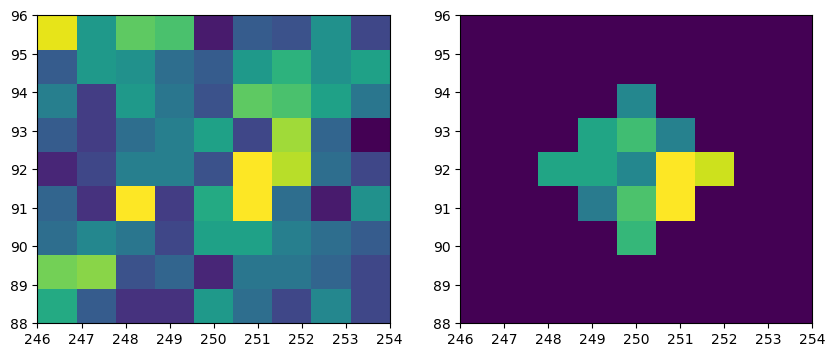

In [98]:
One(x=250,y=92,file=filename) # Plots region x=250

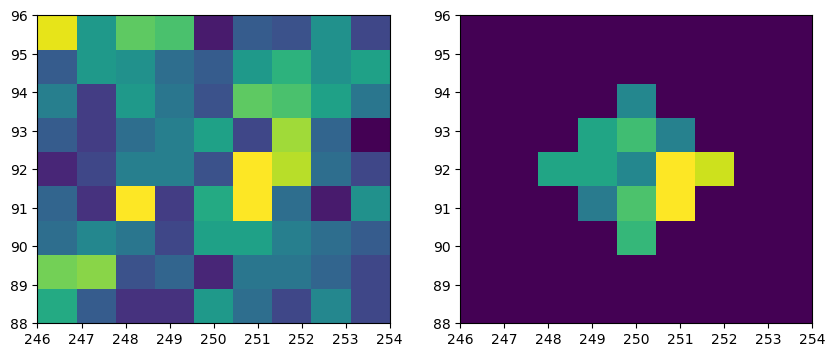

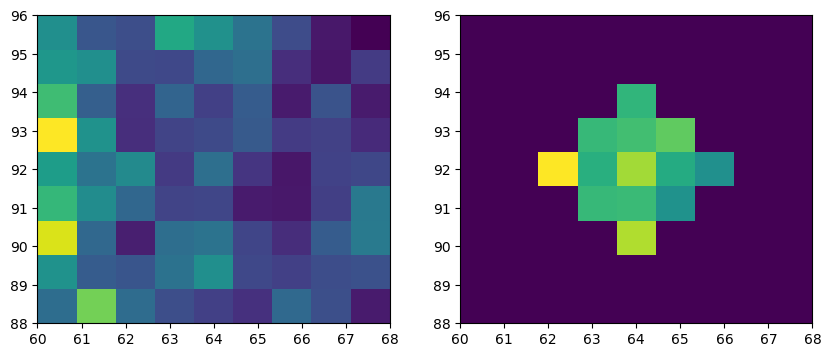

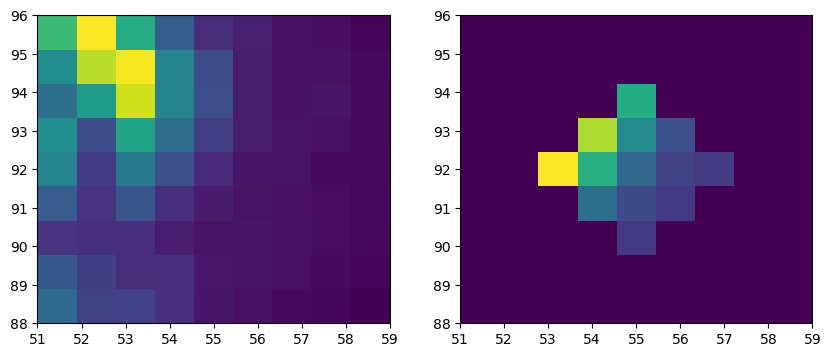

In [30]:
One(x=250,y=92,file=filename)
far=One.data_table
One(x=64,y=92,file=filename)
mid2=One.data_table
One(x=55,y=92,file=filename)
mid1=One.data_table

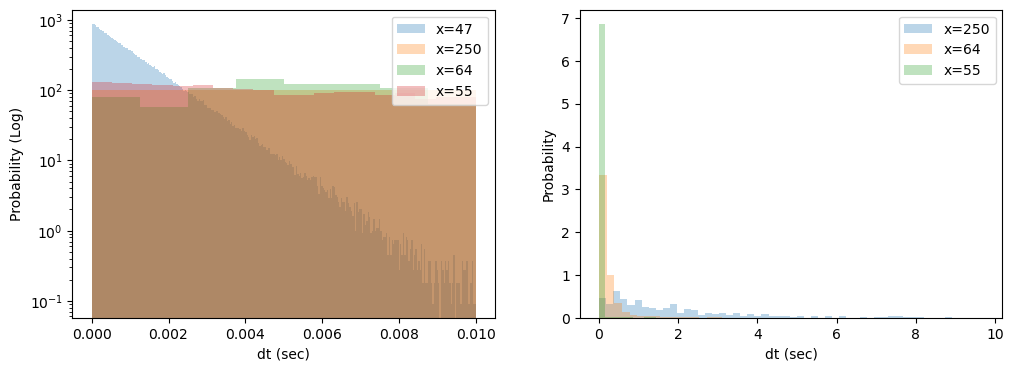

In [90]:
fig,(ax,ax1)=plt.subplots(1,2,figsize=(12,4))
a1,b1,p=ax.hist(data_table["dt"],bins="auto",range=(0,0.01),density=True,alpha=0.3,label="x=47")
a2,b2,p=ax.hist(far["dt"],bins="auto",range=(0,0.01),density=True,alpha=0.3,label="x=250")
a3,b3,p=ax.hist(mid2["dt"],bins="auto",range=(0,0.01),density=True,alpha=0.3,label="x=64")
a4,b4,p=ax.hist(mid1["dt"],bins="auto",range=(0,0.01),density=True,alpha=0.3,label="x=55")
ax.legend()
ax.set_xlabel("dt (sec)")
ax.set_ylabel("Probability (Log)")
ax.set_yscale("log")

ax1.hist(far["dt"],bins=50,density=True,alpha=0.3,label="x=250")
ax1.hist(mid2["dt"],bins=50,density=True,alpha=0.3,label="x=64")
ax1.hist(mid1["dt"],bins=50,density=True,alpha=0.3,label="x=55")
plt.legend()
ax1.set_xlabel("dt (sec)")
ax1.set_ylabel("Probability")

plt.show()

In [93]:
print (len(b1),len(b2),len(b3),len(b4)) #bin sizes of log plot above. 

274 2 9 20


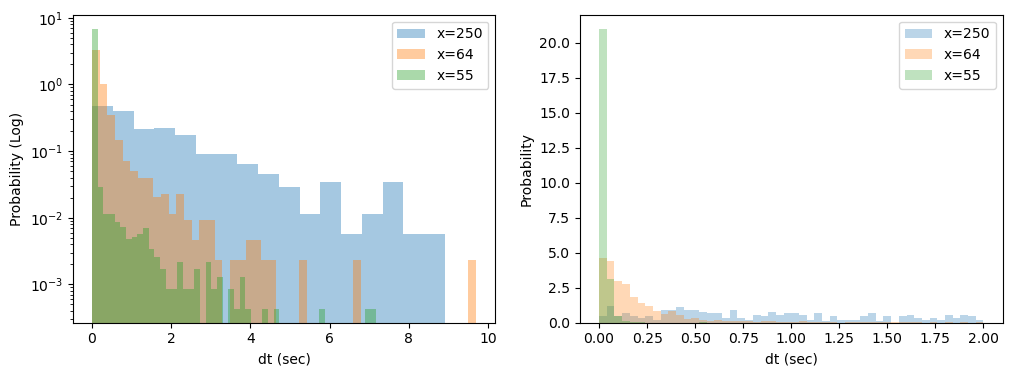

In [96]:
fig,(ax,ax1)=plt.subplots(1,2,figsize=(12,4))

ax.hist(far["dt"],bins="auto",density=True,alpha=0.4,label="x=250")
ax.hist(mid2["dt"],bins=50,density=True,alpha=0.4,label="x=64")
ax.hist(mid1["dt"],bins=50,density=True,alpha=0.4,label="x=55")
ax.legend()
ax.set_xlabel("dt (sec)")
ax.set_ylabel("Probability (Log)")
ax.set_yscale("log")

ax1.hist(far["dt"],bins=50,range=(0,2),density=True,alpha=0.3,label="x=250")
ax1.hist(mid2["dt"],bins=50,range=(0,2),density=True,alpha=0.3,label="x=64")
ax1.hist(mid1["dt"],bins=50,range=(0,2),density=True,alpha=0.3,label="x=55")
plt.legend()
ax1.set_xlabel("dt (sec)")
ax1.set_ylabel("Probability")

plt.show()

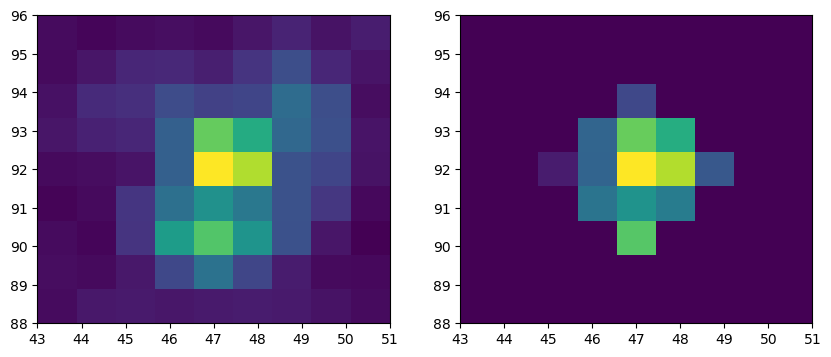

In [54]:
One(x=47,y=92,file=filename)
data_table=One.data_table

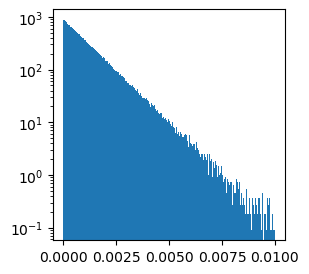

In [65]:
fig,ax=plt.subplots()
ax.hist(data_table["dt"],range=(0,0.01),bins="auto",density=True)
ax.set_yscale("log")
plt.show()